<a href="https://www.kaggle.com/orlevy11/orf-sartorius-seg?scriptVersionId=87233244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())


1.9.1 True


# cloning Detectron2

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'     

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-i4t8e91w
  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-i4t8e91w
  Resolved https://github.com/facebookresearch/detectron2.git to commit 7cad0a7d95cc8b0c7974cc19e50bded742183555
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 106 kB 296 kB/s            
  Installing build dependencies ... - \ | / - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     |████████████████████████████████| 55 kB 1.0 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 74 kB 1.0 MB/s            
     |████████████████████████████████| 145 kB 1.6 MB/s            
     |████████████████████████████████| 130 kB 3.2 MB/s            
     |████████████████████████████████| 112

# imports
cfg - choosing what model and dataset to refer.

Metadata - for adding segmentatin classes.

Visualizer - for plotting annotations above an image.

model_zoo - colection of nn models for different purposes.


In [3]:
import csv
import cv2
import os
import random
import string

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import detectron2
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger

setup_logger()


<_Logger detectron2 (DEBUG)>

# Data formating
we are feeding new dataset to an exsisting COCO dataset in Detectron2.

The COCO dataset is formatted in JSON and is a collection of

* “info”
* “licenses”
* “images”
* “annotations”
* “categories” 
* “segment info” for Panoptic annotations

In [4]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')
ids, masks=[],[]
#test_names = (dataDir/'test').ls()

# Register new dataset 
* fidding our sartorius dataset into coco-dataset.
* crossvalidationfold5 is a directory of json files that are in a compatible format for Detectron2
* access to our new dataset throw COCO (i.e dataset_dicts_train/valid , metadata_train)


In [5]:
if 'my_dataset_train' in DatasetCatalog.list():
    DatasetCatalog.remove('my_dataset_train')

if "my_dataset_val" in DatasetCatalog.list():
    DatasetCatalog.remove("my_dataset_val")

register_coco_instances('my_dataset_train', {}, "../input/crossvalidationfold5/coco_cell_train_fold3.json", dataDir)
register_coco_instances("my_dataset_val", {}, "../input/crossvalidationfold5/coco_cell_valid_fold3.json", dataDir) 

dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
dataset_dicts_valid = DatasetCatalog.get("my_dataset_val")
metadata_train = MetadataCatalog.get("my_dataset_train")


[02/07 17:51:27 d2.data.datasets.coco]: Loading ../input/crossvalidationfold5/coco_cell_train_fold3.json takes 1.99 seconds.
[02/07 17:51:27 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/crossvalidationfold5/coco_cell_train_fold3.json
[02/07 17:51:29 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/crossvalidationfold5/coco_cell_valid_fold3.json


# Encode - Decode
**encoding RLE - a matrix mask to a tring:**
   * img: numpy array, 1 - mask, 0 - background
   * Returns run length as string formated
    
**decoding RLE - a tring to a mask matrix:**
   * mask_rle: run-length as string formated (start length)
   * shape: (height,width) of array to return 
   * Returns numpy array, 1 - mask, 0 - background

In [6]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    print(runs)
    runs[1::2] -= runs[::2]
    print(runs)
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(520, 704)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

**To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:**

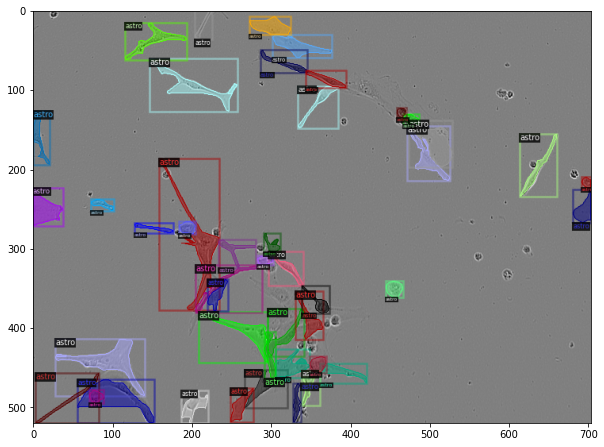

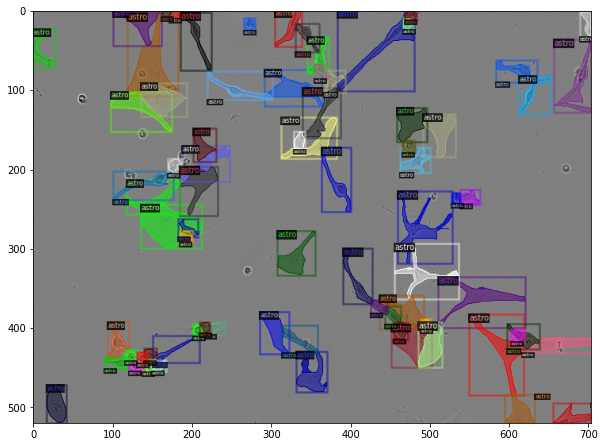

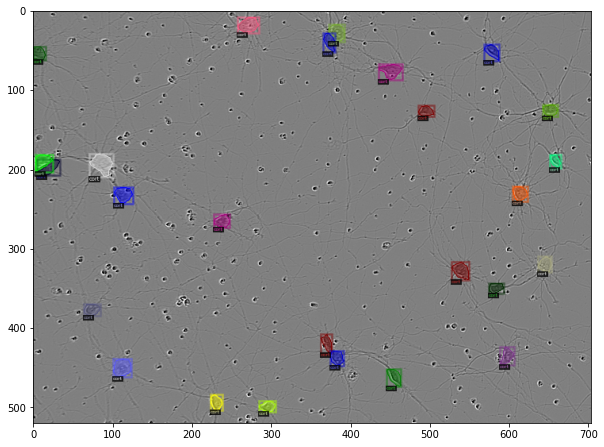

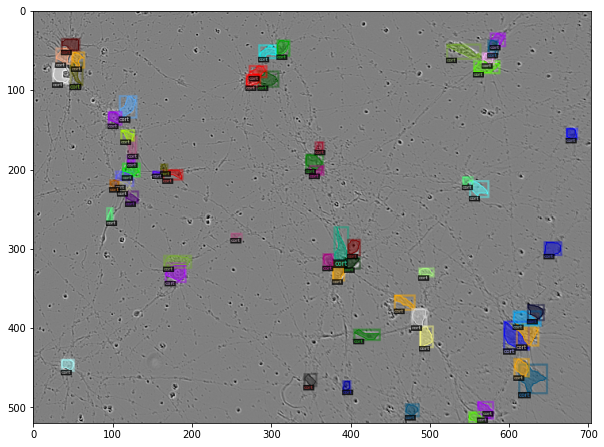

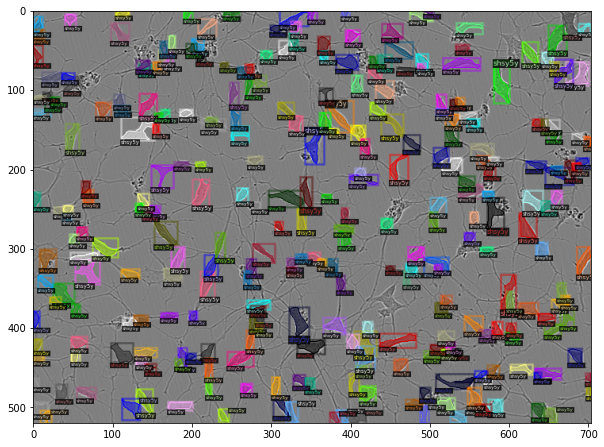

In [7]:
for d in random.sample(dataset_dicts_train, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10,10))
    plt.imshow(out.get_image())
    plt.show()

# Train the model
* set model configurations
* make a path to the output files
* train the model

In [8]:
cfg = get_cfg()
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]
# load model config

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
 

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR

cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = (500, 1000)
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.TEST.EVAL_PERIOD = 250
cfg.SOLVER.CHECKPOINT_PERIOD=250
cfg.MODEL.DEVICE = 'cuda'  #or "cpu"


In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/07 17:51:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:08, 19.8MB/s]                           


[02/07 17:51:56 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it 

[02/07 17:52:30 d2.utils.events]:  eta: 0:26:24  iter: 19  total_loss: 2.924  loss_cls: 1.15  loss_box_reg: 0.3995  loss_mask: 0.6867  loss_rpn_cls: 0.4157  loss_rpn_loc: 0.3319  time: 1.3666  data_time: 0.9533  lr: 0.00025  max_mem: 4140M
[02/07 17:53:17 d2.utils.events]:  eta: 0:36:33  iter: 39  total_loss: 2.529  loss_cls: 0.7606  loss_box_reg: 0.4408  loss_mask: 0.649  loss_rpn_cls: 0.3245  loss_rpn_loc: 0.3044  time: 1.8820  data_time: 1.8470  lr: 0.00025  max_mem: 5801M
[02/07 17:53:52 d2.utils.events]:  eta: 0:27:25  iter: 59  total_loss: 2.428  loss_cls: 0.7559  loss_box_reg: 0.628  loss_mask: 0.5856  loss_rpn_cls: 0.2221  loss_rpn_loc: 0.2891  time: 1.8424  data_time: 1.3552  lr: 0.00025  max_mem: 5801M
[02/07 17:54:23 d2.utils.events]:  eta: 0:21:31  iter: 79  total_loss: 2.382  loss_cls: 0.7086  loss_box_reg: 0.6368  loss_mask: 0.5203  loss_rpn_cls: 0.2219  loss_rpn_loc: 0.2682  time: 1.7599  data_time: 1.1045  lr: 0.00025  max_mem: 5801M
[02/07 17:54:58 d2.utils.events]:  e

# predictions
* update the model weights to our new traind weights.
* plot and save predictions to a csv file - "submission":
    1. ID      |    PREDICTION
    2. No overlaping masks
    3. RLE method



In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

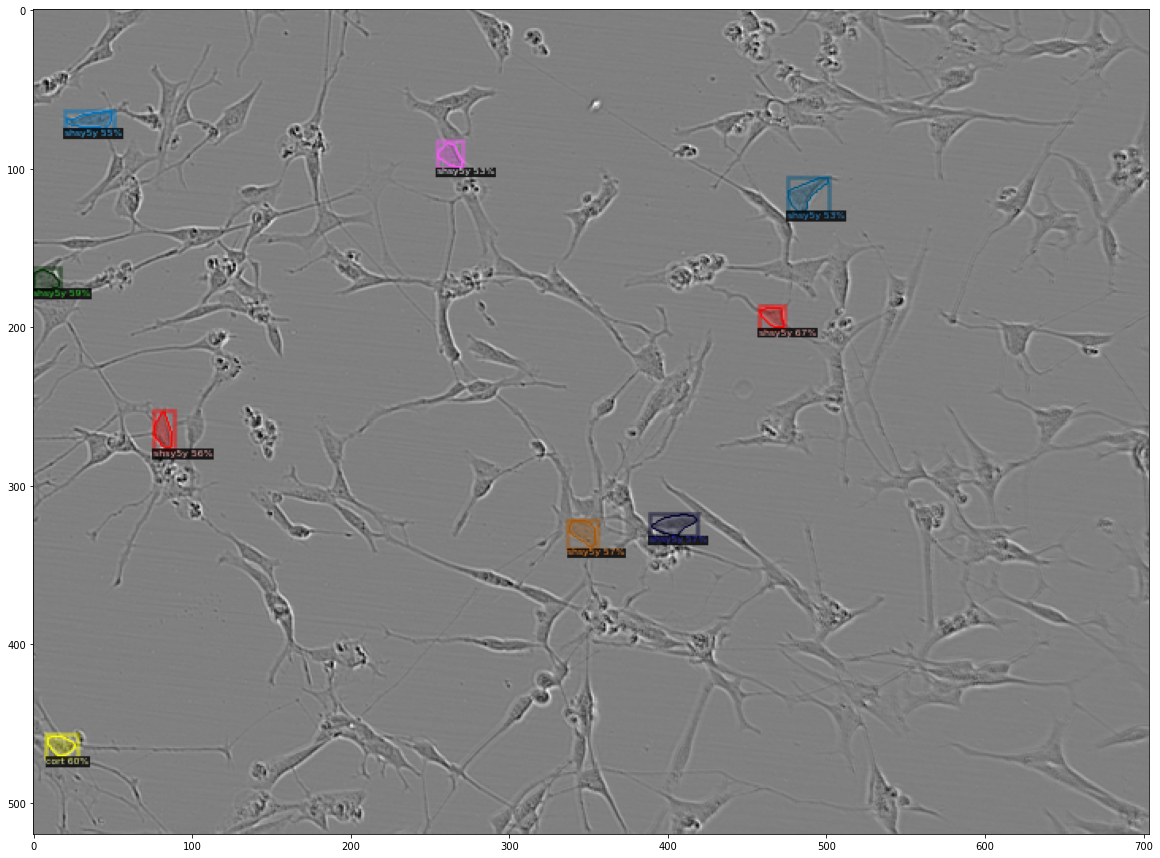

[132815 132825 133516 133530 134219 134234 134923 134938 135628 135642
 136332 136346 137037 137050 137742 137754 138447 138459 139152 139163
 139857 139867 140562 140571 141268 141275]
[132815     10 133516     14 134219     15 134923     15 135628     14
 136332     14 137037     13 137742     12 138447     12 139152     11
 139857     10 140562      9 141268      7]
[322444 322452 323146 323158 323850 323864 324554 324570 325258 325275
 325962 325980 326667 326684 327372 327388 328076 328091 328781 328794
 329486 329497 330191 330200 330896 330902]
[322444      8 323146     12 323850     14 324554     16 325258     17
 325962     18 326667     17 327372     16 328076     15 328781     13
 329486     11 330191      9 330896      6]
[115461 115465 116163 116171 116865 116877 117569 117583 118273 118287
 118977 118992 119681 119697 120385 120402 121089 121106 121793 121810
 122497 122514 123201 123217 123905 123917]
[115461      4 116163      8 116865     12 117569     14 118273     14

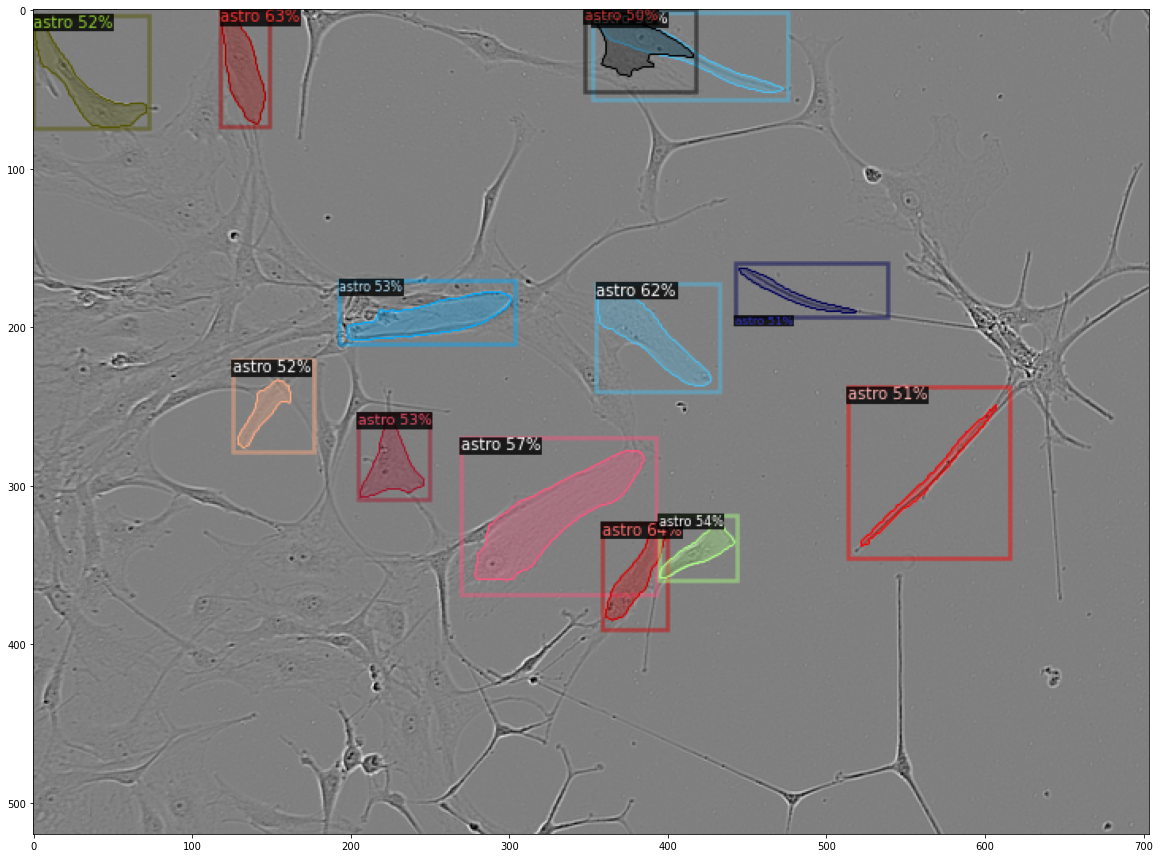

[228489 228495 229191 229200 229895 229904 230598 230608 231302 231312
 232006 232016 232709 232720 233413 233424 234117 234128 234821 234832
 235524 235536 236228 236239 236932 236943 237635 237647 238339 238351
 239043 239054 239746 239758 240449 240462 241153 241166 241856 241869
 242559 242573 243263 243277 243966 243980 244669 244684 245372 245387
 246075 246091 246779 246794 247482 247497 248185 248200 248888 248904
 249591 249607 250294 250311 250997 251015 251700 251719 252403 252422
 253107 253126 253810 253830 254513 254533 255216 255237 255919 255941
 256623 256644 257326 257348 258030 258051 258733 258754 259437 259456
 260141 260160 260845 260863 261548 261566 262252 262269 262955 262972
 263659 263676 264363 264379 265067 265082 265771 265785 266474 266489
 267178 267192 267882 267896 268586 268599 269290 269302 269994 270005
 270700 270706 271406 271407]
[228489      6 229191      9 229895      9 230598     10 231302     10
 232006     10 232709     11 233413     11 2341

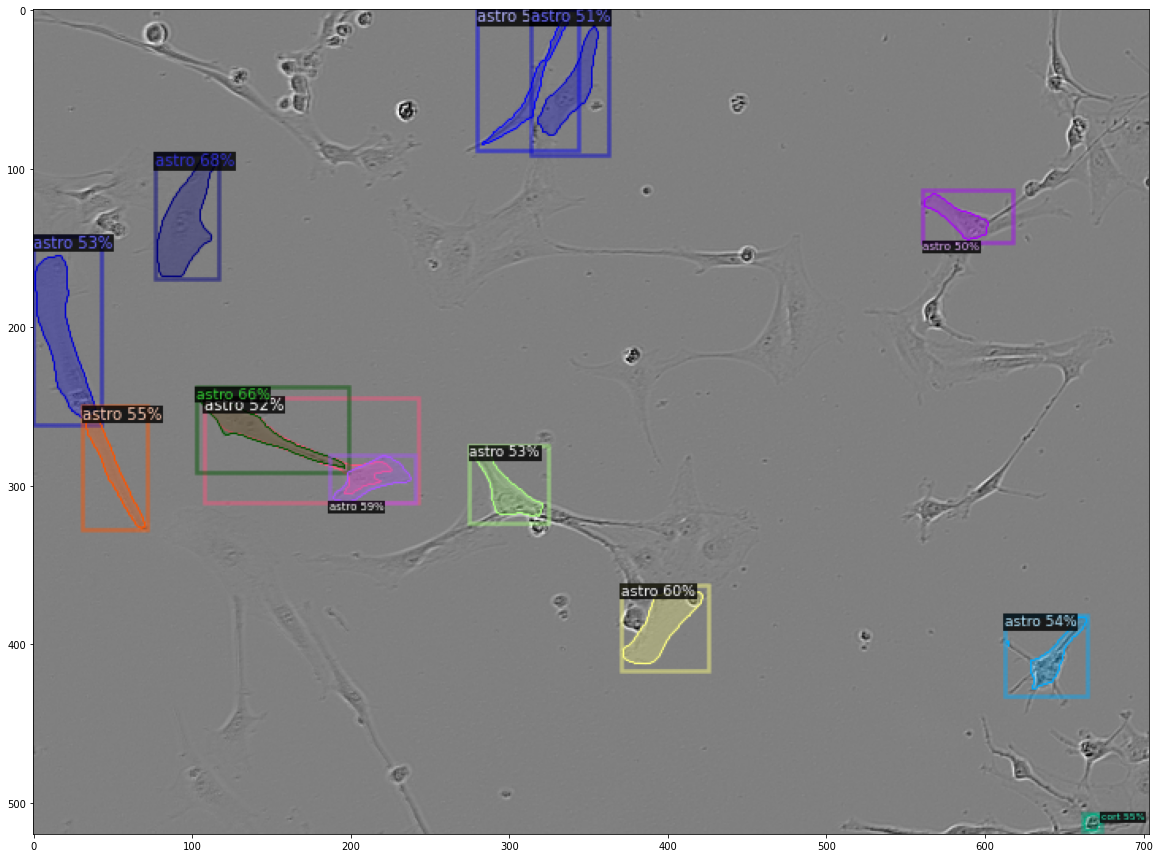

[ 64876  64883  65579  65587  66283  66292  66986  66996  67690  67700
  68393  68404  69096  69108  69800  69812  70503  70515  71207  71219
  71910  71922  72613  72625  73317  73329  74020  74033  74723  74737
  75426  75440  76130  76144  76833  76848  77536  77552  78239  78256
  78942  78960  79645  79663  80349  80367  81052  81071  81755  81775
  82459  82478  83162  83182  83865  83886  84569  84589  85272  85293
  85976  85997  86679  86700  87383  87404  88086  88108  88790  88811
  89493  89515  90197  90219  90900  90923  91604  91627  92307  92331
  93011  93035  93714  93739  94418  94444  95122  95148  95826  95853
  96529  96557  97233  97262  97937  97967  98641  98672  99344  99377
 100048 100082 100752 100786 101456 101490 102159 102194 102863 102897
 103567 103599 104271 104301 104975 105004 105679 105707 106383 106410
 107087 107114 107791 107817 108495 108520 109199 109223 109903 109926
 110607 110630 111311 111333 112015 112036 112720 112740 113424 113443
 11412

In [11]:
with open('submission.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'predicted'])
    test = '../input/sartorius-cell-instance-segmentation/test'
    for filename in os.listdir(test):
        img = cv2.imread(os.path.join(test,filename))
        img_id = filename
        predictions = predictor(img)
        
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=1, instance_mode=ColorMode.IMAGE_BW )
        out = visualizer.draw_instance_predictions(predictions["instances"].to("cpu"))
        plt.figure(figsize=(20,20))
        plt.imshow(out.get_image())
        plt.show()
        
        pred_class = torch.mode(predictions['instances'].pred_classes)[0]
        take = predictions['instances'].scores >= THRESHOLDS[pred_class]
        masks_list = predictions['instances'].pred_masks[take]
        masks_list = masks_list.cpu().numpy()

        used = np.zeros(img.shape[:2], dtype=int)

        for msk in masks_list:
            s= []
            msk = msk * (1-used)
            used += msk
            s = (rle_encode(msk))
            #print(s)
            writer.writerow([img_id, s])
    f.close()

